# TODO


In [2]:
#위키문서 전처리
##PROFILE에서 참조 문장 모두 제거, 원문만 남아있는 것이 필요함

#쿼리 최적화 
##multi query retriever 참조

#리트리버 개발
##

#수집 검증 및 쿼리 재생성
##self-rag 참조

# Settings

In [6]:
# %pip install -q -U langchain langchain_community langchain_core langchain_openai faiss-cpu langchain_anthropic langgraph langchain_google_community langchain_google_vertexai langchain-google-genai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#수집할 아티스트 데이터
we_art_name = 'FROMIS_9'

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

import faiss
from langchain_openai import OpenAIEmbeddings
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_community import BigQueryVectorStore
from langchain_google_community.bigquery import BigQueryLoader
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

import vertexai

In [3]:
from langchain_anthropic import ChatAnthropic
from langchain_google_vertexai import ChatVertexAI
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField
import os

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from pydantic  import BaseModel, Field
from operator import itemgetter

from time import time

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field

## LLM 생성

In [9]:
#API KEY 셋팅
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

#LLM 모델 생성 with Config

llm = (
    ChatAnthropic(model_name='claude-3-5-sonnet-20240620')
    .configurable_alternatives(
        ConfigurableField(
            id = 'llm',
            name="LLM Model",
            description="The base LLM model",
        ),
        default_key="claude3_5_sonnet",
        claude3_haiku=ChatAnthropic(model_name='claude-3-haiku-20240307'),
        gpt4o_mini = ChatOpenAI(model = 'gpt-4o-mini'),
        gpt3_5 = ChatOpenAI(model = 'gpt-3.5-turbo'),
        gemini_flash = ChatVertexAI(model="gemini-1.5-flash-001")
    )
    .configurable_fields(
        temperature=ConfigurableField(
            id="temperature",
            name="LLM Temperature",
            description="The temperature of the LLM",
        ),
        max_tokens = ConfigurableField(
            id="max_token",
            name="Maximum input Tokens",
            description="Maximum limit of input Tokens",
        ),
    )
)

In [11]:
llm = llm.with_config(configurable={
            "llm": "gpt4o_mini", #model_name,
            # "llm":"gemini_flash",
            "temparature": 0, #temp,
            "max_tokens": None #max_tokens
        })

## LangSmith 셋팅

In [6]:
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# 위키문서 로드 & 벡터스토어 생성

In [7]:
#저장된 문서 불러오기
PROJECT_ID = "wev-dev-analytics"
REGION = "asia-northeast3"
DATASET_ID = "namu_wiki"
TABLE_ID = "artists"

vertexai.init(project=PROJECT_ID, location=REGION)

# OpenAI의 "text-embedding-3-large" 모델을 사용하여 1024차원의 임베딩을 생성하는 객체를 초기화합니다.
embeddings_docs = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1024, api_key = os.environ["OPENAI_API_KEY"])
# embeddings_docs = VertexAIEmbeddings(model_name="text-multilingual-embedding-002")


#임베딩할 문서 로더
bigquery_loader = BigQueryLoader(
    query=f"""
        SELECT *
             , json_value(metadata, '$.parent_page_toc_item') as parent_paper
        FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
        WHERE artist_info = "{we_art_name}"
    """,
    project=PROJECT_ID,
    page_content_columns = "page_content", #벡터화할 텍스트 지정
    metadata_columns  = ["artist_info","toc_item","abs_page_toc_item","parent_paper","page_url"] #메타데이터 지정
)

documents = bigquery_loader.load()

#Splitter 생성
text_splitter = RecursiveCharacterTextSplitter(
  # 나무위키 한 문단에 적절하다고 판단하는 청크 사이즈
  chunk_size=700,
  # 적절하다고 생각하는 overlap
  chunk_overlap=150,
  # 문자열 길이를 계산하는 함수를 지정합니다.
  length_function=len,
  # 구분자로 정규식을 사용할지 여부를 설정합니다.
  is_separator_regex=False,
)

book = []

# metadata를 page_content에 포함시키는 함수
def concatenate_metadata_into_content(doc):
    doc.page_content = f"{doc.metadata['abs_page_toc_item']}\n\n"+re.sub('page_content:', '', f"{doc.page_content}")
    return doc

#Chunking with abs_page_toc_item
for element in documents:
  # text_splitter를 사용하여 텍스트를 문서로 분할합니다.
  papers = text_splitter.create_documents(texts = [element.page_content], metadatas = [element.metadata])
  #papers.page_content 앞에 element.metadata[abs_page_toc_item] concat하기
  book.extend(list(map(concatenate_metadata_into_content, papers)))


#FAISS 벡터스토어 생성
index = faiss.IndexFlatL2(len(embeddings_docs.embed_query("Hello world")))
# index = faiss.IndexFlatL2(len(embeddings_docs.embed(texts = ["hello world"], embeddings_task_type = 'RETRIEVAL_DOCUMENT')))

##Sementic Search를 위한 Chunking 문서 임베딩
vstr = FAISS(
    embedding_function=embeddings_docs,
    index=index,
    docstore= InMemoryDocstore(),
    index_to_docstore_id={}
)

# Convert documents to embeddings and store them
# vstr.add_documents(documents=book)

# 질문 Set

In [164]:
# 지시: Answer the question
# 형식: JsonOutputParser
# 맥락: context (documents or retriever)
# 역할: SystemPrompt

# 원하는 데이터 구조를 정의합니다.
class Ctry(BaseModel):
    ctry: list = Field(description="ISO 3166-1 alpha-2 형식, 최소 1개 이상")

class Gender(BaseModel):
    gender: str = Field(description="남성과 관련된 이름이나 단어가 나오면 '남성'으로, 여성과 관련된 이름이나 단어가 나오면 '여성'으로 출력")

class Genre(BaseModel):
    genre: list = Field(description="문서 내 순서를 따르고, 모든 장르를 출력")

class Label(BaseModel):
    label_name: list = Field(description="고유명사만 출력하고 **괄호와 괄호 안의 내용은 반드시 제거**, 2개 이상인 경우 솔로 활동을 앞 순서에, 그룹 활동은 뒷 순서에 배치해주세요.")

class Debut(BaseModel):
    debut_date: str = Field(description="'yyyy-MM-dd' 형식으로 출력")

class MemberInfo(BaseModel):
    member_list: list = Field(description="문서 내 순서를 따른다.")

class MemberNumber(BaseModel):
    member_cnt: int = Field(description="숫자로만 출력하세요.")

class Fandom(BaseModel):
    fandom_name: str = Field(description="고유명사만 출력하고, 반복 문자열은 중복을 제거하고 출력합니다.")


# 컬럼명 & 컬럼용 질문 Dict 생성
singer_queries = {
    "ctry":{
        "question":"활동 국가는?",
        "format":JsonOutputParser(pydantic_object=Ctry),
      }, #???
    "gender":{"question":"인물의 성별을 유추하세요. (힌트: 보이그룹, 걸그룹, 혼성듀오, 형, 누나, 오빠)",
              "format":JsonOutputParser(pydantic_object=Gender),
              "loc":"개요" #(솔로)PROFILE > 가족 or (그룹)개요
    },
    "genre": {"question":"음악 장르는?",
              # "format":"가장 관련성이 큰 장르 2개로 정리해줘. [장르 A, 장르 B]와 같이 쉼표로 구분된 한 줄로 출력하세요.",
              "format":JsonOutputParser(pydantic_object=Genre),
              "loc":"PROFILE" #PROFILE > 장르
    },
    "label_name": {"question":"엔터테인먼트 회사명은?",
                   "format":JsonOutputParser(pydantic_object=Label),
                   "loc":"PROFILE" #PROFILE > 소속사
    },
    "debut_date": {"question":"데뷔일자는?",
                   "format":JsonOutputParser(pydantic_object=Debut),
                   "loc":"PROFILE" #PROFILE > 데뷔일
    },
    "member_list": {"question":"주어진 문서에서 등장하는 사람의 이름을 모두 나열하세요",
                    "format":JsonOutputParser(pydantic_object=MemberInfo),
                    "loc":"멤버" #멤버
    },
    "member_num": {"question":"주어진 문서에서 등장하는 사람의 이름을 카운트하세요",
                   "format":JsonOutputParser(pydantic_object=MemberNumber),
                   "loc":"멤버" #멤버
    },
    "fandom_name": {"question":"팬덤명은?",
                    "format":JsonOutputParser(pydantic_object=Fandom),
                    "loc":"PROFILE" #PROFILE > 팬덤
    }
}

# Tool 정의

In [11]:
#툴은 크게 4개
#0. 전달받은 문서에서 메타데이터를 생성하는 툴
#1. 프로필에서 메타데이터 생성
## 1.1. 0.에 프로필을 전달
#2. 개요/멤버/팬덤 문서에서 메타데이터 생성
## 2.1. 0.에 개요/멤버/팬덤을 각각 전달
## 2.2. 2.1.에서 생성한 3개의 df를 머지
#3. 리트리버에서 메타데이터 생성
## 3.1. 흠...
#4. 1~3의 결과를 종합해서 최종 데이터를 만드는 툴

#나중에는...
#아티스트명을 입력받아서 이 아티스트가 가수/배우/그 외에 따라서 질문 set을 다르게 가져와야함.

# Agent 생성

In [11]:
#Workflow
##1. (미구현) 아티스트의 성격 분류 / 가수(현재 구현 ver), 배우, 셀럽
##2. 총 5개 (프로필 / 개요 / 멤버 / 팬덤 + 전체 문서 리트리빙)의 툴을 실행
##2.1. 각 결과값으로 pandas dataframe을 생성
##2.2. 프로필 / 개요 / 멤버 / 팬덤은 Map-reduce 적용 검토
##3. 5개 문서 결과값에 대해 가중치를 적용해서 dataframe merge

In [123]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class ArtistMeta(TypedDict):
    ctry: list #= Field(description="ISO 3166-1 alpha-2 형식, 최소 1개 이상")
    gender: str #= Field(description="남성과 관련된 단어가 나오면 '남성'으로, 여성과 관련된 단어가 나오면 '여성'으로 출력")
    genre: list #= Field(description="문서 내 순서를 따르고, 모든 장르를 출력")
    label_name: list #= Field(description="고유명사만 출력하고 **괄호와 괄호 안의 내용은 반드시 제거**, 2개 이상인 경우 솔로 활동을 앞 순서에, 그룹 활동은 뒷 순서에 배치해주세요.")
    debut_date: str #= Field(description="'yyyy-MM-dd' 형식으로 출력")
    member_list: list #= Field(description="문서 내 순서를 따른다.")
    member_cnt: int #= Field(description="숫자로만 출력하세요.")
    fandom_name: str #= Field(description="고유명사만 출력하고, 반복되는 문자열은 하나로 합쳐주세요.")

class OneMetaState(TypedDict):
    questions: dict #= Field(description="아티스트에 대한 특정 질문")
    doc: str #= Field(description="아티스트 데이터를 찾아볼 문서")
    page: str
    answers: Annotated[List[dict], operator.add]
    metadatas: Annotated[List[dict], operator.add]

## 지정된 문서 원문에서 메타데이터를 생성하는 Tool

In [124]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def answer_from_origin(state: OneMetaState):

  question = state['qnf']['question']
  format = state['qnf']['format']
  doc = state['doc']
  answers = state['answers']

  # 시스템 프롬프트 설정
  system_prompt = SystemMessagePromptTemplate.from_template(
      """
      You are a biographical dictionary agent. Your sole purpose is to provide factual information based strictly on the provided <Context>.

      - **Behavior:**
        - Be friendly and helpful without being overly chatty.
        - Do not use any prior knowledge beyond the <Context>.
        - If the answer cannot be found within the <Context>, respond with "None"

      - **Input Structure:**
        - The input will be provided using the following tags:
          ```
          <Context>
          ...
          </Context>
          <Question>
          ...
          </Question>
          <Format>
          ...
          </Format>
          ```

      - **Response Guidelines:**
        - **Do not** include the `<Context>`, `<Question>`, or `<Format>` tags in your response.
        - **Only** provide the answer as specified in the `<Format>` section.
        - Ensure the response strictly adheres to the format provided.
      """
  )

  human_prompt = HumanMessagePromptTemplate.from_template(
      """<Context>{context}</Context>\n\n
      <Question>{question}</Question>\n\n
      <Format>{format_instructions}</Format>"""
  )
  prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])
  if isinstance(format, JsonOutputParser):
    prompt = prompt.partial(format_instructions=format.get_format_instructions())

  chain = {
          'context': itemgetter('context') | RunnablePassthrough()
        , 'question': 
        ('question') | RunnablePassthrough()
    } | prompt | llm | format

  answer = chain.invoke({"question": question, "context":doc})
  # print(answer)

  # meta.update(answer)
  return {"answers":[answer]}

In [125]:
from langgraph.constants import Send

def init_graph(state:OneMetaState):
  pass

def split_question(state:OneMetaState):
  qnf = state['questions']
  doc = state['doc']
  return [Send("answer_from_origin", {"qnf":qnf[key], "doc":doc, "answers": []}) for key, value in qnf.items()]

def merge_answers(state:OneMetaState):
  answers = state['answers']
  meta = {}
  for answer in answers:
    meta.update(answer)
  meta.update({"page":state['page']})
  # print('meta:', meta)
  return {"metadatas":[meta]}

In [126]:
#질문Set과 특정 페이지 원문이 input
#원문에 대해 질문Set의 각각을 별도로 질문
#meta에 list로 merge한 것이 output

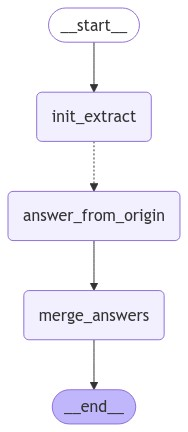

In [127]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
onemeta_builder = StateGraph(OneMetaState)

#node
onemeta_builder.add_node("init_extract", init_graph)
onemeta_builder.add_node("answer_from_origin", answer_from_origin)
onemeta_builder.add_node("merge_answers", merge_answers)

#edge
onemeta_builder.add_edge(START, "init_extract")
onemeta_builder.add_conditional_edges("init_extract", split_question, ["answer_from_origin"])
onemeta_builder.add_edge("answer_from_origin", "merge_answers")
onemeta_builder.add_edge("merge_answers", END)

# Compile
graph = onemeta_builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [128]:
#전체 그래프
#질문Set과 documents가 input
#List[Dict]가 output / 또는 pd.Dataframe이 output

In [129]:
import pandas as pd

class OverallGraphState(TypedDict):
    questions: dict
    documents: list
    pages: list
    metadatas: Annotated[List[dict], operator.add]
    mergeset: pd.DataFrame

In [130]:
from langgraph.constants import Send

def get_origins(state:OverallGraphState):
    return {"pages":state['pages'], "questions":singer_queries, "documents":documents}

def check_empty_origins(state:OverallGraphState):
    pages = state['pages']
    
    if len(pages) == 0:
        return "merge_metas"
    else:
        doc = "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == pages[0]])
        if doc == "":
            return "empty_meta"
        else:
            return Send("make_meta", {"questions":state['questions'], "doc":doc, "page":pages[0]})

def remove_finish_origin(state:OverallGraphState):
    # print(state['pages'])
    # print(state['metadatas'])
    return {"pages":state['pages'][1:]}

def empty_meta(state:OverallGraphState):
    return {"pages":state['pages'][1:]}

def merge_metas(state:OverallGraphState):
    #가중치 (순위로)
    ##page|ctry|gender|genre|label|debut|member_info|member_number|fandom_name
    ##PROFILE|?|2|1|1|1|3|3|1|
    ##개요|?|1|2|2|2|2|2|
    ##멤버|?|3|2|3|1|1|2|
    ##팬덤|?|4|2|3|3|3|1|
    metadatas = state['metadatas']

    # 각 컬럼별 우선순위를 저장하는 딕셔너리
    priority_dict = {
        'ctry': ['PROFILE', '개요', '멤버', '팬덤'],
        'gender': ['개요', 'PROFILE', '멤버', '팬덤'],
        'genre': ['PROFILE', '개요', '멤버', '팬덤'],
        'label_name': ['PROFIEL', '개요', '멤버', '팬덤'],
        'debut_date': ['PROFILE', '개요', '멤버', '팬덤'],
        'member_list': ['멤버', 'PROFILE', '개요', '팬덤'],
        'member_cnt': ['멤버', 'PROFILE', '개요', '팬덤'],
        'fandom_name': ['PROFILE', '팬덤', '멤버', '개요']
    }

    # 병합된 딕셔너리를 초기화
    merged_data = {}

    # 컬럼별 우선순위에 따라 값을 선택하여 병합
    for key, priority_list in priority_dict.items():
        for page in priority_list:
            for meta in metadatas:
                if meta['page'] == page and key in meta and meta[key] != 'None' and meta[key] != []:
                    merged_data[key] = meta[key]
                    break  # 첫 번째로 발견한 유효한 값 사용 후 중단
            if key in merged_data:
                break # key 값이 할당된 경우 루프 중단

    # 병합 결과를 데이터프레임으로 변환
    df = pd.DataFrame([merged_data])

    print(df)
    # print("merge metas!")
    
    return {"mergeset":df}

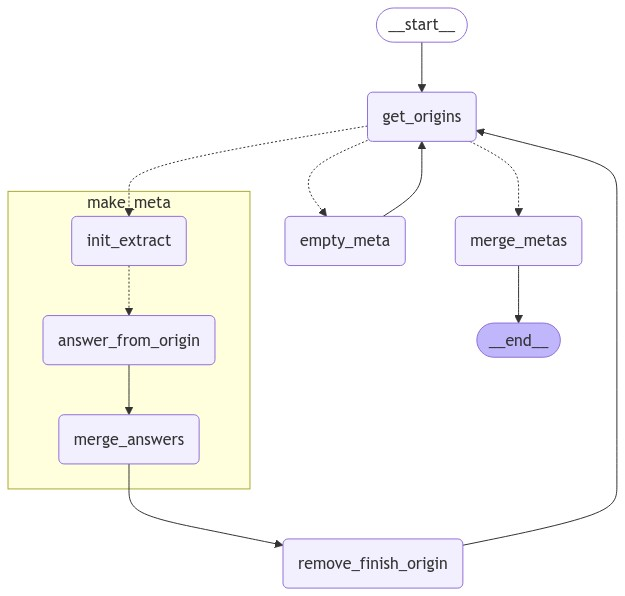

In [131]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Add nodes and edges
builder = StateGraph(OverallGraphState)
builder.add_node("get_origins", get_origins)
builder.add_node("make_meta", onemeta_builder.compile())
builder.add_node("empty_meta", empty_meta)
builder.add_node("merge_metas", merge_metas)
builder.add_node("remove_finish_origin", remove_finish_origin)
builder.add_edge(START, "get_origins")
builder.add_conditional_edges("get_origins", check_empty_origins, ["merge_metas","empty_meta","make_meta"])
builder.add_edge("make_meta", "remove_finish_origin")
builder.add_edge("remove_finish_origin", "get_origins")
builder.add_edge("empty_meta", "get_origins")
builder.add_edge("merge_metas", END)

# Compile
memory = MemorySaver()
# graph = builder.compile(checkpointer=memory)
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Run

In [168]:
event = graph.invoke({"pages":["PROFILE","개요","멤버","팬덤"]})

       ctry gender                        genre label_name  debut_date  \
0  [KR, JP]     남성  [K-POP, 댄스, 록/메탈, 일렉트로닉 뮤직]     [판타지오]  2023-06-15   

                          member_list  member_cnt  \
0  [진수, 카엘, 타쿠마, 준우, 도현, 이안, 지은호, 은섭]           9   

                                         fandom_name  
0  LUV8 (러베이트)LUV8 (러베이트)LUV8 (러베이트)LUV8 (러베이트)LU...  


In [169]:
event.get("mergeset","")

,ctry,gender,genre,label_name,debut_date,member_list,member_cnt,fandom_name
0,"[KR, JP]",남성,"[K-POP, 댄스, 록/메탈, 일렉트로닉 뮤직]",[판타지오],2023-06-15,"[진수, 카엘, 타쿠마, 준우, 도현, 이안, 지은호, 은섭]",9,LUV8 (러베이트)LUV8 (러베이트)LUV8 (러베이트)LUV8 (러베이트)LU...


## 리트리빙해서 메타데이터를 생성하는 Tool

In [24]:
# 패키지 업데이트
# %pip install -qU langchain-teddynote

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Convert documents to embeddings and store them
vstr.add_documents(documents=book)

['619d2a16-b726-482b-b345-f05903dbb7cb',
 '1cca3bd6-06fa-4426-abd6-8be8b62051fd',
 'e48a8037-b8fb-46c0-a7b9-69a03b526c8d',
 '3fa2b061-bfbb-4d9c-a9e7-ffc4b53e21dc',
 '308fd921-441c-459a-9321-18a7de2f5f5f',
 '94a817f0-a740-4d9b-8921-cc06656dff64',
 'f3bf64e1-9102-4687-b9ad-1144f97ab638',
 '45522b3c-1d98-4fc4-b0b9-d3171e705a37',
 '66d8472c-1e5e-4f1d-855f-d90129a7c464',
 '19a44dfb-f78c-481a-915e-aba8f65cfd4d',
 'f482e39b-f8f6-45c2-9bfa-4d1846ab0a10',
 '7956e330-ad60-44db-a80a-9b737de9b72e',
 'd99dc709-783b-4724-b551-a841ab02b737',
 'd1556b3a-b2d3-45ee-ba00-459a0171d3f0',
 '6952e750-3af6-4ca6-bb1d-75c01a87fdb1',
 '74014d0f-9225-47d2-b35e-8aa00cf099cc',
 '187aac2d-fdc3-496a-9604-48f9091412cd',
 'cc400f2c-907b-4537-a2d2-43cb4d86cb71',
 '3120c976-eb5d-4699-ac47-ffd3f76a1115',
 'ee257056-1a80-46ad-bf1a-37db43787a26',
 '5bb83f03-1bbf-441d-9a04-71200e6cf857',
 '924c3a6b-eb90-47ee-b473-3f1ff945b6f3',
 '3afdaadf-197b-4a81-b1f4-eea1368487e0',
 '5cca766a-c3b3-443f-96ca-f7e3d0f22def',
 '1709ef74-642d-

In [22]:
page = vstr.similarity_search(query = "노지선의 나이는?", k = 20)

In [23]:
page

[Document(metadata={'page_url': 'https://namu.wiki/w/프로미스나인', 'artist_info': 'FROMIS_9', 'toc_item': '멤버', 'abs_page_toc_item': '멤버', 'parent_paper': ''}, page_content='멤버\n\n 해당 멤버별 포지션의 경우 공식 일본 웹사이트를 근거로 서술되었으나 노지선의 언급에 의하면 캡틴(리더)외 포지션을 나눠본 적이 없다고 한다. 그나마 멤버들이 확실히 인지하고 있는 포지션은 캡틴(이새롬), 부캡틴(송하영)(#fn-8; 데뷔 쇼케이스 당일에 V LIVE에서 공개된 공식 포지션이다. 새롬이 휴식기를 갖고 있을때 하영이가 캡틴 대행을 맡기도 했다.), 메인보컬(박지원, 송하영)(#fn-9; 오프더레코드 시절 발매한 FUN FACTORY 키트앨범에서 두 메인보컬이라고 밝힌바 있고 멤버들도 직접 언급했다.)과 메인댄서(이서연, 송하영)(#fn-10; 혀니콤보에 출연했을때 멤버들이 서연, 하영을 메댄이라 불렀다.)뿐이다.  ,,,,,이새롬,송하영,박지원,노지선,1997. 01. 07. (27세), 대한민국 행정구 속령,캡틴서브보컬,1997. 09. 29. (26세), 대한민국 행정구 속령,메인보컬메인댄서,1998. 03. 20. (26세), 대한민국 행정구 속령,메인보컬,1998. 11. 23. (25세), 대한민국 행정구 속령,서브보컬,,,,,이서연,이채영,이나경,백지헌,2000. 01. 22. (24세), 대한민국 행정구 속령,메인댄서리드보컬,2000. 05. 14. (24세), 대한민국 행정구 속령,서브보컬,2000. 06. 01. (24세), 대한민국 행정구 속령,서브보컬,2003. 04. 17.'),
 Document(metadata={'page_url': 'https://namu.wiki/w/프로미스나인', 'artist_info': 'FROMIS_9', 'toc_item': '2022년', 'abs_page_toc_item': '활동/

# 프롬프트 최적화

In [ ]:
# 컬럼명 & 컬럼용 질문 Dict 생성
qq = singer_queries['member_list']['question']
loc = '멤버'

# 시스템 프롬프트 설정
system_prompt = SystemMessagePromptTemplate.from_template(
    """
    You are a biographical dictionary agent. Provide only factual information based solely on the provided Context.
    Be friendly and helpful without being overly chatty. Do not use any prior knowledge beyond the Context.
    If the answer is not found in the Context, respond with "None" Follow the specified Output Format below.

    The input will be provided using the following tags:
    <Context>...</Context>
    <Question>...</Question>

    Please extract the Context, Question, and Format from these tags and answer the query accordingly.
    """
)

human_prompt = HumanMessagePromptTemplate.from_template(
    """<Context>n{context}</Context>\n\n
    <Question>{question}</Question>\n\n
    """
)
prompt = ChatPromptTemplate.from_messages([system_prompt, human_prompt])
chain = {
      'context': itemgetter('context') | RunnablePassthrough()
    , 'question': itemgetter('question') | RunnablePassthrough()
} | prompt | llm | StrOutputParser()

result = chain.with_config(configurable={
            #   "llm": 'gpt4o_mini',
            "llm":"gemini_flash",
              "temparature": 0,
              "max_tokens": None #max_tokens
          }).invoke({"question": qq, 'context': "\n\n".join([doc.page_content for doc in documents if doc.metadata['abs_page_toc_item'] == loc])})

print(result)

In [ ]:
type(chain)

In [ ]:
qq

In [ ]:
"\n\n".join([doc.page_content for doc in documents if doc.metadata['parent_paper'] == '팬덤'])